In [10]:
!pip install --upgrade pip setuptools wheel --quiet
!pip install yfinance pmdarima xgboost lightgbm dask[complete] ta --quiet
!pip install --upgrade statsmodels --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


AAPL (2488, 6) 2016-01-04 00:00:00 2025-11-21 00:00:00
MSFT (2488, 6) 2016-01-04 00:00:00 2025-11-21 00:00:00
GOOG (2488, 6) 2016-01-04 00:00:00 2025-11-21 00:00:00
AMZN (2488, 6) 2016-01-04 00:00:00 2025-11-21 00:00:00
TSLA (2488, 6) 2016-01-04 00:00:00 2025-11-21 00:00:00
AAPL cleaned -> (2576, 6)
MSFT cleaned -> (2576, 6)
GOOG cleaned -> (2578, 6)
AMZN cleaned -> (2575, 6)
TSLA cleaned -> (2578, 6)
Saved /content/stock_pipeline_results/AAPL_price_and_returns.png


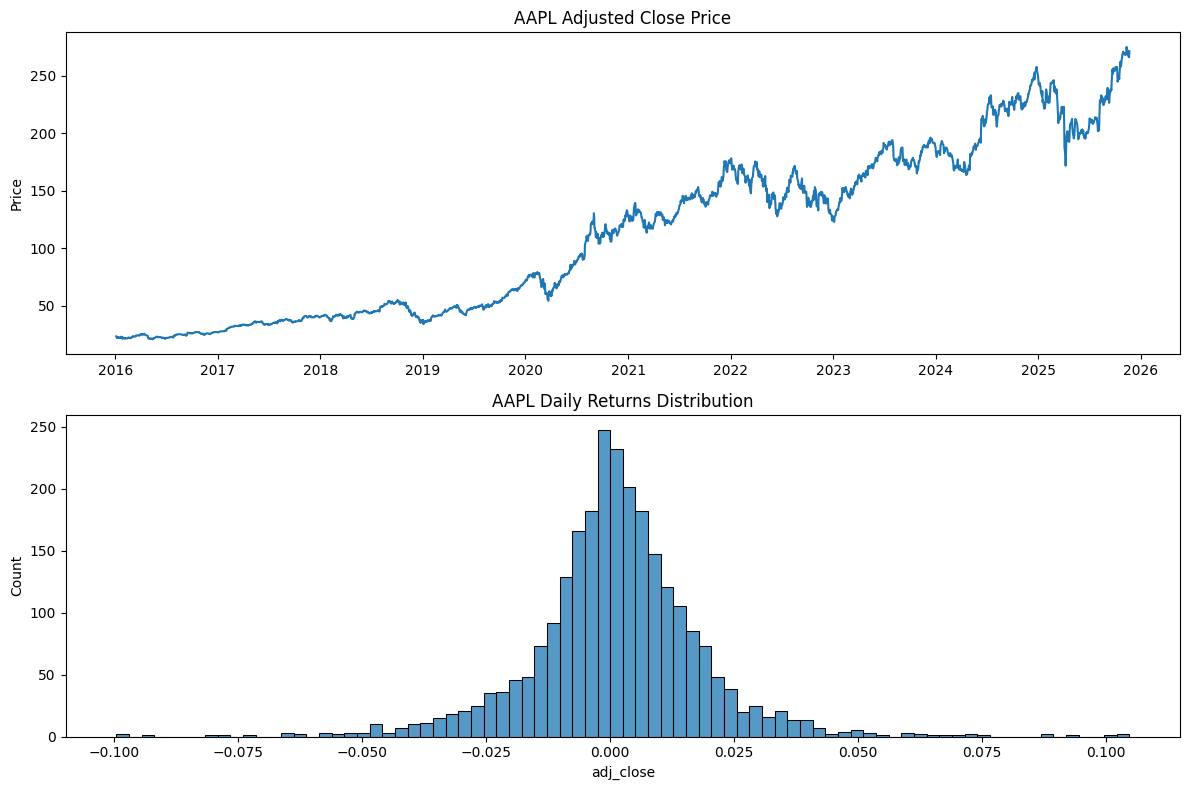

Saved /content/stock_pipeline_results/MSFT_price_and_returns.png


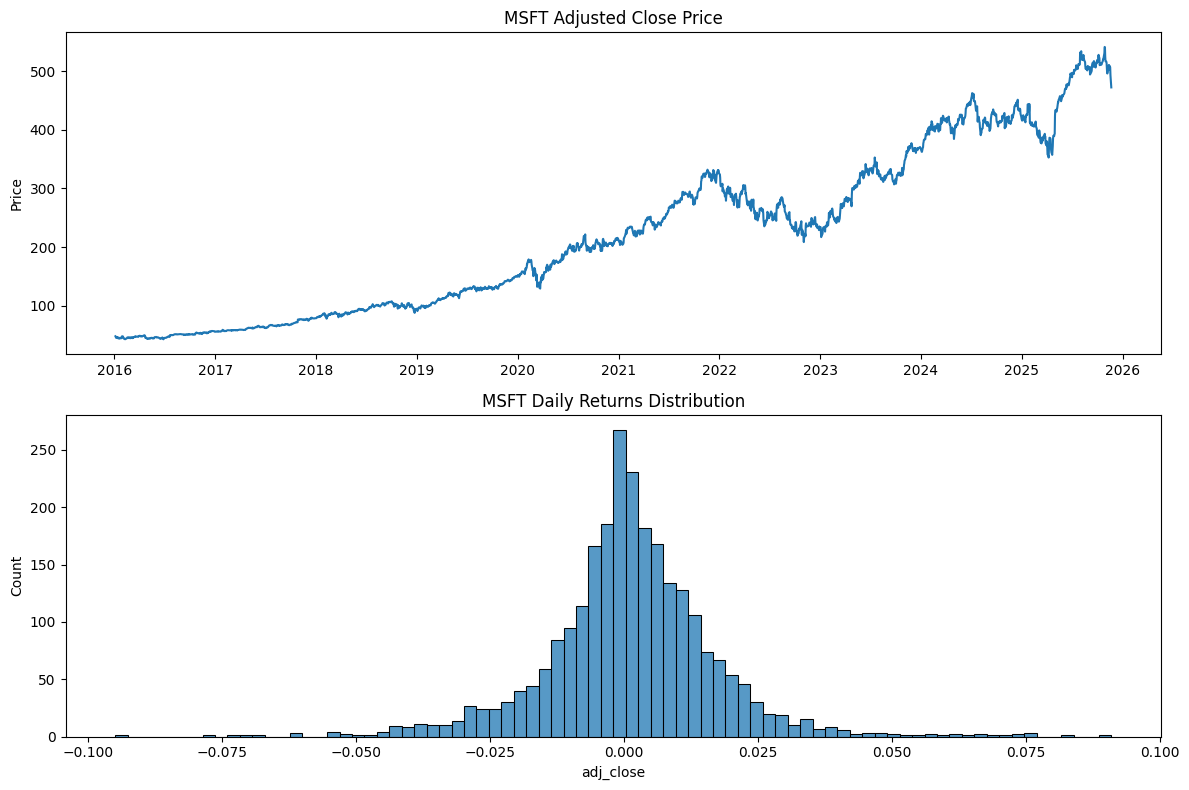

Saved /content/stock_pipeline_results/GOOG_price_and_returns.png


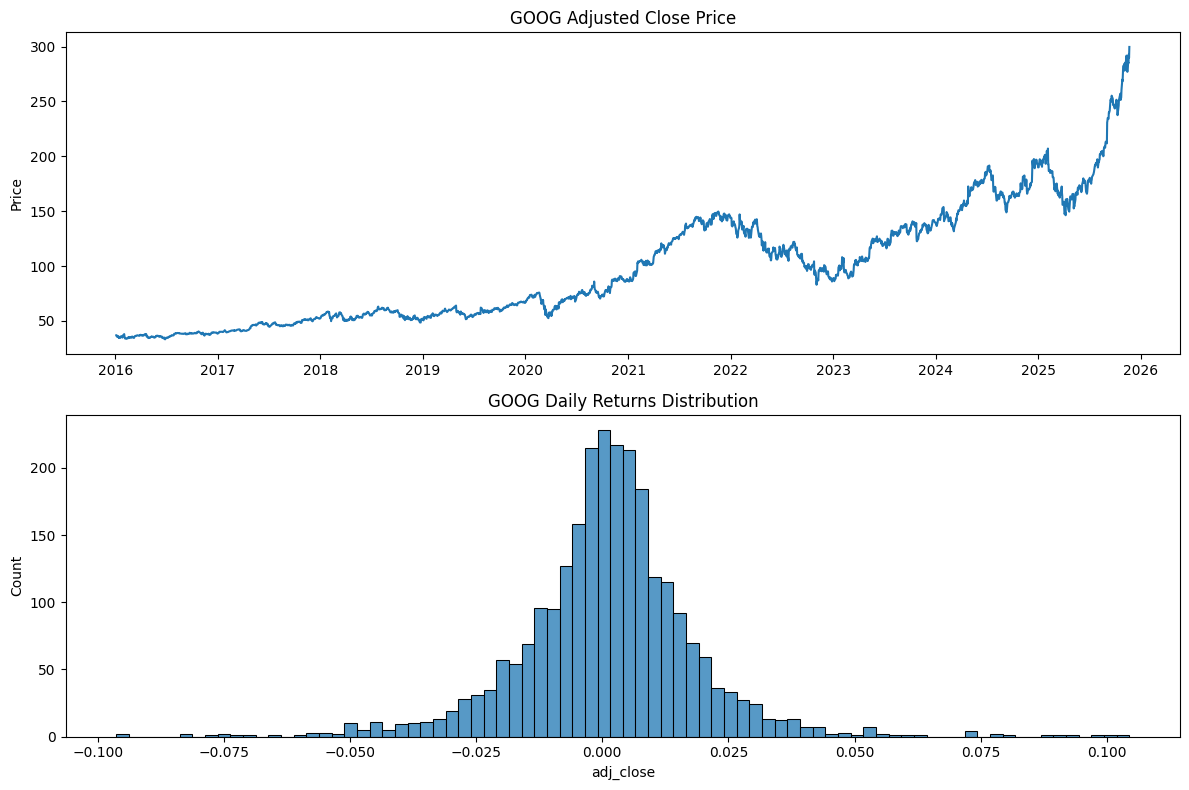

Saved /content/stock_pipeline_results/AMZN_price_and_returns.png


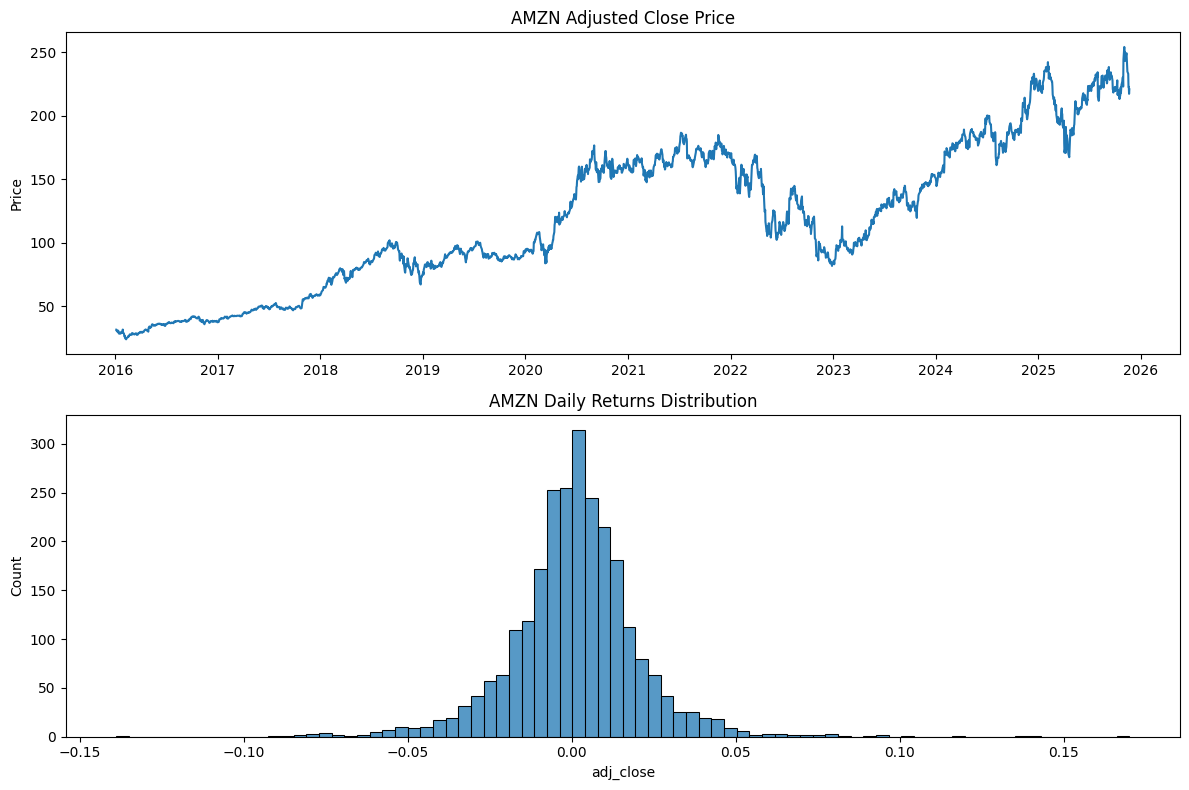

Saved /content/stock_pipeline_results/TSLA_price_and_returns.png


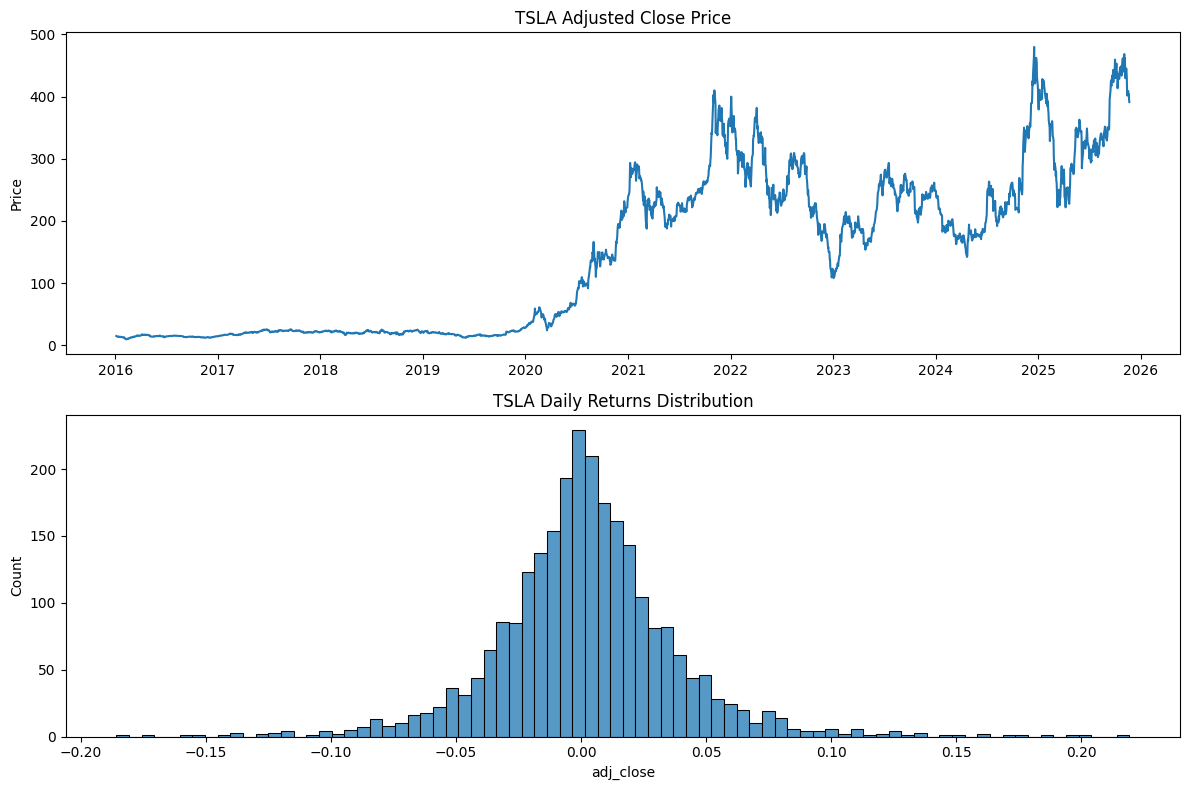

Saved /content/stock_pipeline_results/return_correlation.png


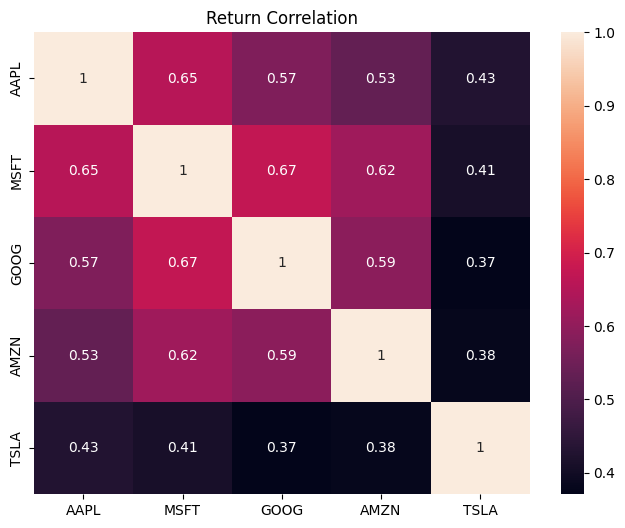

Features for AAPL: (2526, 21)
Features for MSFT: (2526, 21)
Features for GOOG: (2528, 21)
Features for AMZN: (2525, 21)
Features for TSLA: (2528, 21)
ARIMA training from 2016-01-05 00:00:00 to 2025-05-23 00:00:00
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10740.630, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10732.422, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10732.438, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10741.179, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10734.378, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10734.404, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10730.885, Time=1.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10730.024, Time=0.87 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10730.842, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10731.926, Time=1.83 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10731.977, Time=1.91 sec
 ARIMA(

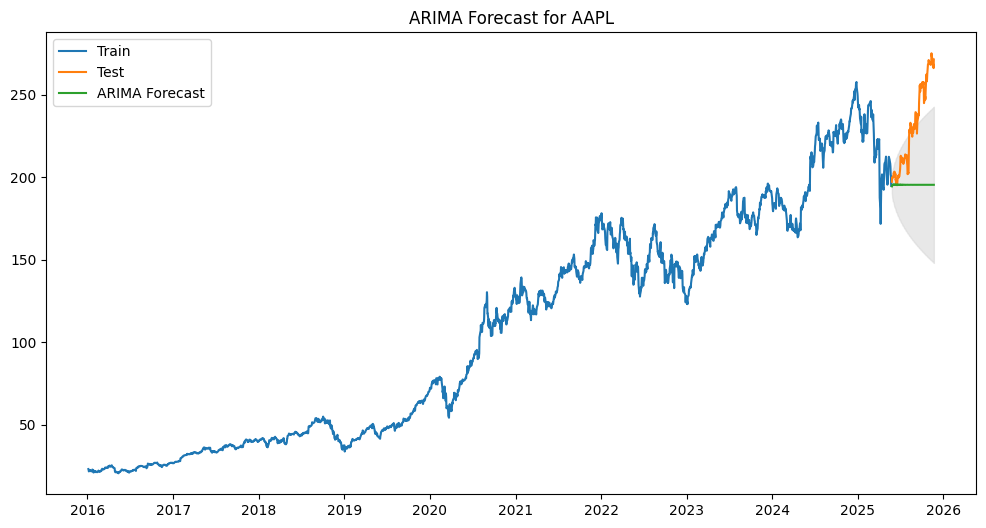

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
XGBoost Test RMSE: 8.278772855948867 MAE: 5.578522379084151 MAPE: 2.2399231146027123
Saved /content/stock_pipeline_results/AAPL_xgb_predictions.png


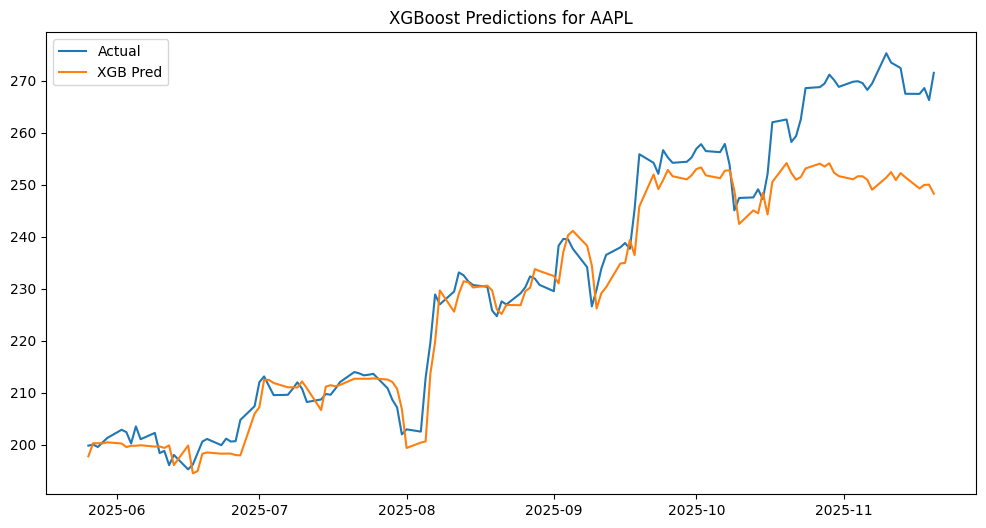

Model comparison for AAPL
ARIMA -> RMSE: 43.82453310216264 MAE: 35.78570349684441 MAPE: 14.465735015925437
XGBoost -> RMSE: 8.278772855948867 MAE: 5.578522379084151 MAPE: 2.2399231146027123

- Use walk-forward validation for realistic performance estimates.
- Avoid lookahead bias: ensure features are created only from information available at prediction time.
- For trading strategy simulation, convert predictions into signals (e.g., long if predicted next-day return > threshold) and compute P&L, Sharpe ratio, max drawdown.
- Include transaction costs and slippage assumptions.

Results saved in /content/stock_pipeline_results
Create visuals, write a report (Markdown/PowerPoint) summarizing methods & results. Include:
- Data cleaning steps, anomalies handled
- EDA findings (trends, seasonality, correlations)
- Feature engineering rationale
- Model details and hyperparameters
- Metrics and visual comparisons
- Trading implications and recommended next steps

Submit your assignment to form

In [12]:


import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

# ARIMA
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Optional: Dask for large datasets
import dask.dataframe as dd

# ---------- CELL 1: Configuration & Helper Functions ----------
# Configuration
TICKERS = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA']  # replace/add to 5-10 tickers
START = '2016-01-01'
END = pd.Timestamp.today().strftime('%Y-%m-%d')
FREQ = '1d'
RESULTS_DIR = '/content/stock_pipeline_results'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Metrics
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # avoid divide by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Save plot helper
def save_fig(fig, name):
    path = os.path.join(RESULTS_DIR, name)
    fig.savefig(path, bbox_inches='tight')
    print(f'Saved {path}')

# ---------- CELL 2: Download data (yfinance) ----------
# This will download OHLCV for chosen tickers
raw = {}
for t in TICKERS:
    print('Downloading', t)
    df = yf.download(t, start=START, end=END, progress=False)
    if df.empty:
        print(f'Warning: {t} returned empty dataframe')
    else:
        # If columns are MultiIndex (e.g., from yfinance group_by='ticker' or non-standard output)
        if isinstance(df.columns, pd.MultiIndex):
            # Attempt to flatten MultiIndex columns, keeping the column name from the first level
            df.columns = [col[0] if isinstance(col, tuple) and len(col) > 0 else col for col in df.columns]

        # Standardize column names to lowercase and replace spaces with underscores
        df.columns = [col.lower().replace(' ', '_') for col in df.columns]

        # Ensure 'adj_close' column exists. If 'adj_close' is not present, use 'close' if available.
        if 'adj_close' not in df.columns and 'close' in df.columns:
            df['adj_close'] = df['close']
        elif 'adj_close' not in df.columns:
            print(f"Warning: No 'adj_close' or 'close' column found for {t}. Skipping {t}.")
            continue # Skip this ticker if essential columns are missing

        df.index = pd.to_datetime(df.index)
        raw[t] = df

# Quick check
for t, df in raw.items():
    print(t, df.shape, df.index.min(), df.index.max())

# ---------- CELL 3: Data Cleaning & Preparation ----------
# Steps: reindex to trading days, forward/backfill small gaps, handle anomalies
from pandas.tseries.offsets import BDay

cleaned = {}
for t, df in raw.items():
    # Reindex to business days between min and max
    idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq=BDay())
    df = df.reindex(idx)

    # Interpolate small missing OHLC values (limit set to 3 days) and fill volume with 0
    df[['open','high','low','close','adj_close']] = df[['open','high','low','close','adj_close']].interpolate(limit=3)
    df['volume'] = df['volume'].fillna(0)

    # Remove rows with NaN beyond repairs
    df = df.dropna()

    # Remove obvious outliers using z-score on returns
    df['ret'] = df['adj_close'].pct_change()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    df = df[(np.abs((df['ret'] - df['ret'].mean()) / (df['ret'].std() + 1e-9)) < 6)]
    df = df.drop(columns=['ret'])

    cleaned[t] = df.copy()
    print(f'{t} cleaned ->', df.shape)

# ---------- CELL 4: Exploratory Data Analysis (EDA) ----------
# Visualize price series, returns distribution, rolling stats
for t, df in cleaned.items():
    fig, ax = plt.subplots(2,1, figsize=(12,8))
    ax[0].plot(df.index, df['adj_close'])
    ax[0].set_title(f'{t} Adjusted Close Price')
    ax[0].set_ylabel('Price')

    returns = df['adj_close'].pct_change().dropna()
    sns.histplot(returns, bins=80, ax=ax[1])
    ax[1].set_title(f'{t} Daily Returns Distribution')
    plt.tight_layout()
    save_fig(fig, f'{t}_price_and_returns.png')
    plt.show()

# Correlation heatmap across tickers using returns (joined)
returns_df = pd.concat([cleaned[t]['adj_close'].pct_change().rename(t) for t in cleaned], axis=1)
returns_df = returns_df.dropna()
fig = plt.figure(figsize=(8,6))
sns.heatmap(returns_df.corr(), annot=True)
plt.title('Return Correlation')
save_fig(fig, 'return_correlation.png')
plt.show()

# ---------- CELL 5: Feature Engineering ----------
# We'll create lag features, rolling mean/std, percentage change, RSI etc using ta library
import ta
features = {}
for t, df in cleaned.items():
    X = pd.DataFrame(index=df.index)
    X['adj_close'] = df['adj_close']
    X['volume'] = df['volume']

    # Lag features
    for lag in [1,2,3,5,10]:
        X[f'lag_{lag}'] = X['adj_close'].shift(lag)

    # Returns
    X['ret_1'] = X['adj_close'].pct_change(1)
    X['ret_5'] = X['adj_close'].pct_change(5)

    # Rolling stats
    for w in [5,10,20,50]:
        X[f'ma_{w}'] = X['adj_close'].rolling(window=w).mean()
        X[f'std_{w}'] = X['adj_close'].rolling(window=w).std()

    # Technical indicators - RSI and MACD
    X['rsi_14'] = ta.momentum.rsi(df['adj_close'], window=14)
    macd = ta.trend.MACD(df['adj_close'])
    X['macd'] = macd.macd()
    X['macd_diff'] = macd.macd_diff()

    # Target variable: next-day adjusted close
    X['target'] = X['adj_close'].shift(-1)

    X = X.dropna()
    features[t] = X
    print(f'Features for {t}:', X.shape)

# Save a features sample
for t in list(features.keys())[:2]:
    features[t].head().to_csv(os.path.join(RESULTS_DIR, f'{t}_features_sample.csv'))

# ---------- CELL 6: Train/Test Split (time-based) ----------
# We'll use the last N days as test. Also prepare a function to run models per ticker.
TEST_SIZE_DAYS = 180

def time_train_test_split(df_features, test_size_days=TEST_SIZE_DAYS):
    train_end = df_features.index.max() - pd.Timedelta(days=test_size_days)
    train = df_features[df_features.index <= train_end]
    test = df_features[df_features.index > train_end]
    return train, test

# ---------- CELL 7: ARIMA Modeling (univariate) ----------
# We'll fit ARIMA on the adjusted close series for a selected ticker (e.g., first ticker)
selected = TICKERS[0]
series = cleaned[selected]['adj_close']
train_end_date = series.index.max() - pd.Timedelta(days=TEST_SIZE_DAYS)
series_train = series[series.index <= train_end_date]
series_test = series[series.index > train_end_date]

print('ARIMA training from', series_train.index.min(), 'to', series_train.index.max())

# Use auto_arima to identify p,d,q (seasonal disabled by default)
auto = pm.auto_arima(series_train, start_p=0, start_q=0, max_p=5, max_q=5,
                     seasonal=False, information_criterion='aic', trace=True,
                     error_action='ignore', suppress_warnings=True, stepwise=True)
print('Auto ARIMA summary:')
print(auto.summary())

# Fit SARIMAX with discovered order
order = auto.order
model = SARIMAX(series_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast next len(series_test) steps
n_forecast = len(series_test)
forecast_res = model_fit.get_forecast(steps=n_forecast)
fc_mean = forecast_res.predicted_mean
fc_ci = forecast_res.conf_int()

# Align index
fc_mean.index = series_test.index
fc_ci.index = series_test.index

# Evaluate
arima_rmse = rmse(series_test.values, fc_mean.values)
arima_mae = mean_absolute_error(series_test.values, fc_mean.values)
arima_mape = mape(series_test.values, fc_mean.values)
print('ARIMA Test RMSE:', arima_rmse, 'MAE:', arima_mae, 'MAPE:', arima_mape)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(series_train.index, series_train, label='Train')
ax.plot(series_test.index, series_test, label='Test')
ax.plot(fc_mean.index, fc_mean, label='ARIMA Forecast')
ax.fill_between(fc_ci.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color='lightgrey', alpha=0.5)
ax.legend()
ax.set_title(f'ARIMA Forecast for {selected}')
save_fig(fig, f'{selected}_arima_forecast.png')
plt.show()

# Save ARIMA metrics
with open(os.path.join(RESULTS_DIR, f'{selected}_arima_metrics.txt'), 'w') as f:
    f.write(f'order: {order}\n')
    f.write(f'RMSE: {arima_rmse}\nMAE: {arima_mae}\nMAPE: {arima_mape}\n')

# ---------- CELL 8: Gradient Boosting Model (XGBoost) ----------
# We'll train a model to predict next-day price using engineered features
X = features[selected].drop(columns=['target'])
y = features[selected]['target']

train, test = time_train_test_split(features[selected])
X_train, y_train = train.drop(columns=['target']), train['target']
X_test, y_test = test.drop(columns=['target']), test['target']

# Use XGBoost with TimeSeriesSplit for quick hyperparam tuning
tscv = TimeSeriesSplit(n_splits=5)
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=2, random_state=42)

param_dist = {
    'n_estimators': [50,100,200],
    'max_depth': [3,4,6,8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(model_xgb, param_distributions=param_dist, n_iter=12, cv=tscv,
                            scoring='neg_root_mean_squared_error', n_jobs=1, random_state=42, verbose=1)
search.fit(X_train, y_train)
print('Best params:', search.best_params_)

best_xgb = search.best_estimator_

# Predict
y_pred_xgb = best_xgb.predict(X_test)

xgb_rmse = rmse(y_test, y_pred_xgb)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_mape = mape(y_test, y_pred_xgb)
print('XGBoost Test RMSE:', xgb_rmse, 'MAE:', xgb_mae, 'MAPE:', xgb_mape)

# Feature importance
fi = pd.Series(best_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi.head(20).to_csv(os.path.join(RESULTS_DIR, f'{selected}_xgb_feature_importance.csv'))

# Plot predictions vs actual
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(y_test.index, y_test, label='Actual')
ax.plot(y_test.index, y_pred_xgb, label='XGB Pred')
ax.legend()
ax.set_title(f'XGBoost Predictions for {selected}')
save_fig(fig, f'{selected}_xgb_predictions.png')
plt.show()

# Save XGBoost metrics
with open(os.path.join(RESULTS_DIR, f'{selected}_xgb_metrics.txt'), 'w') as f:
    f.write(str(search.best_params_) + '\n')
    f.write(f'RMSE: {xgb_rmse}\nMAE: {xgb_mae}\nMAPE: {xgb_mape}\n')

# ---------- CELL 9: Compare Models & Backtesting Notes ----------
print('Model comparison for', selected)
print('ARIMA -> RMSE:', arima_rmse, 'MAE:', arima_mae, 'MAPE:', arima_mape)
print('XGBoost -> RMSE:', xgb_rmse, 'MAE:', xgb_mae, 'MAPE:', xgb_mape)

# Backtesting considerations (instructions to include in report)
backtesting_notes = '''
- Use walk-forward validation for realistic performance estimates.
- Avoid lookahead bias: ensure features are created only from information available at prediction time.
- For trading strategy simulation, convert predictions into signals (e.g., long if predicted next-day return > threshold) and compute P&L, Sharpe ratio, max drawdown.
- Include transaction costs and slippage assumptions.
'''
with open(os.path.join(RESULTS_DIR, 'backtesting_notes.txt'), 'w') as f:
    f.write(backtesting_notes)
print(backtesting_notes)

# ---------- CELL 10: Packaging & Submission Guidance ----------
# Save notebooks, code, CSVs to /content and push to GitHub from Colab or download and push locally.
# Example commands (run in Colab cell if you want to push to your GitHub via token - optional):

print('Results saved in', RESULTS_DIR)
print('Create visuals, write a report (Markdown/PowerPoint) summarizing methods & results. Include:')
print('- Data cleaning steps, anomalies handled')
print('- EDA findings (trends, seasonality, correlations)')
print('- Feature engineering rationale')
print('- Model details and hyperparameters')
print('- Metrics and visual comparisons')
print('- Trading implications and recommended next steps')

# Provide submission link reminder
print('\nSubmit your assignment to forms.gle/VwH2EzXv38PuGCEK7 along with your GitHub/Jupyter/SQL code links and screenshots of outputs.')

# End of notebook template
print('\nNotebook run complete. Review the generated files in the results directory, add narrative to your report, and submit.')

In [11]:
!pip install ta



In [5]:
!pip install pmdarima

  Using cached pmdarima-2.1.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (8.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.5 MB/s  0:00:00
